In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
import pickle
from flask_docker.constants import CONTINOUS_COLUMNS

# EDA 

https://www.kaggle.com/datasets/madhuraatmarambhagat/crop-recommendation-dataset/data

In [ ]:
df=pd.read_csv("data/crop_data.csv")
df.head(5)

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB


In [7]:
df.isnull().sum()

N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64

In [8]:
df.duplicated().sum()

np.int64(0)

In [9]:
df.describe()

,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


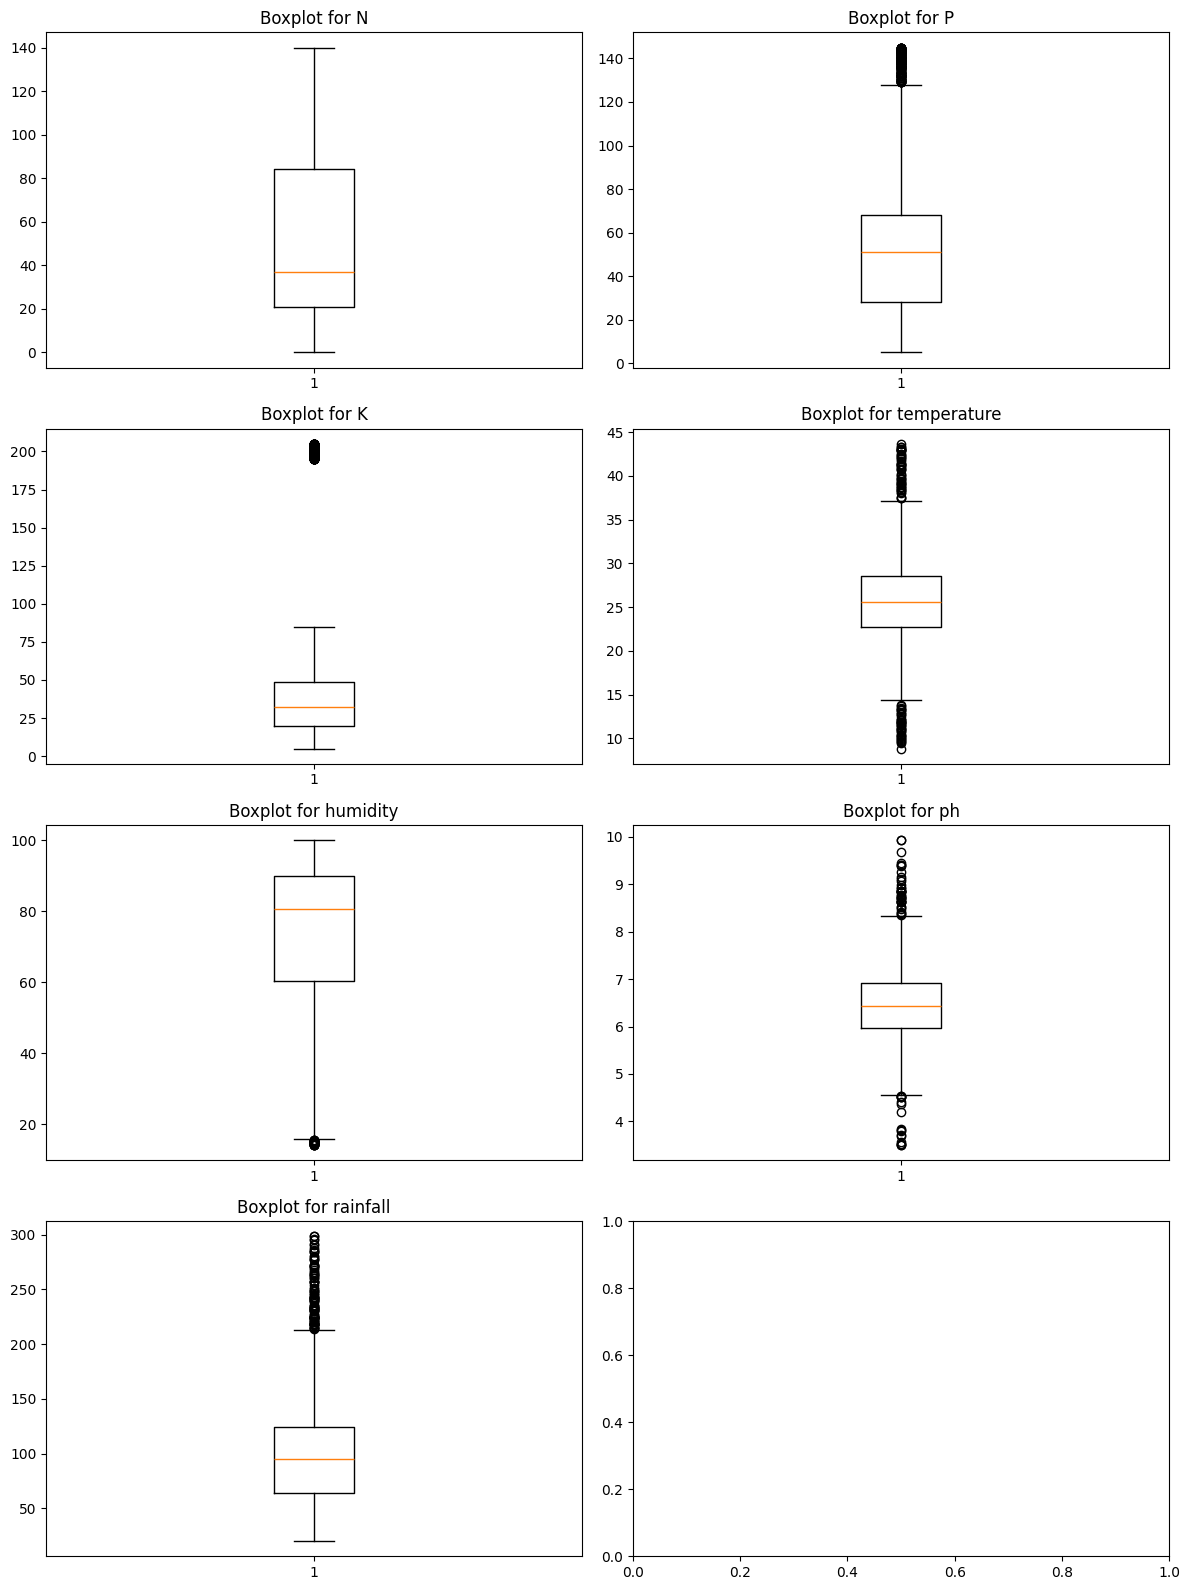

In [10]:
num_col = df.select_dtypes(include="number")
cols = num_col.columns
n = len(cols)
fig, axs = plt.subplots(4, 2, figsize=(12, 16)) 
axs = axs.ravel()
for i in range(n):
    axs[i].boxplot(df[cols[i]].dropna())
    axs[i].set_title(f"Boxplot for {cols[i]}")
plt.tight_layout()
plt.show()

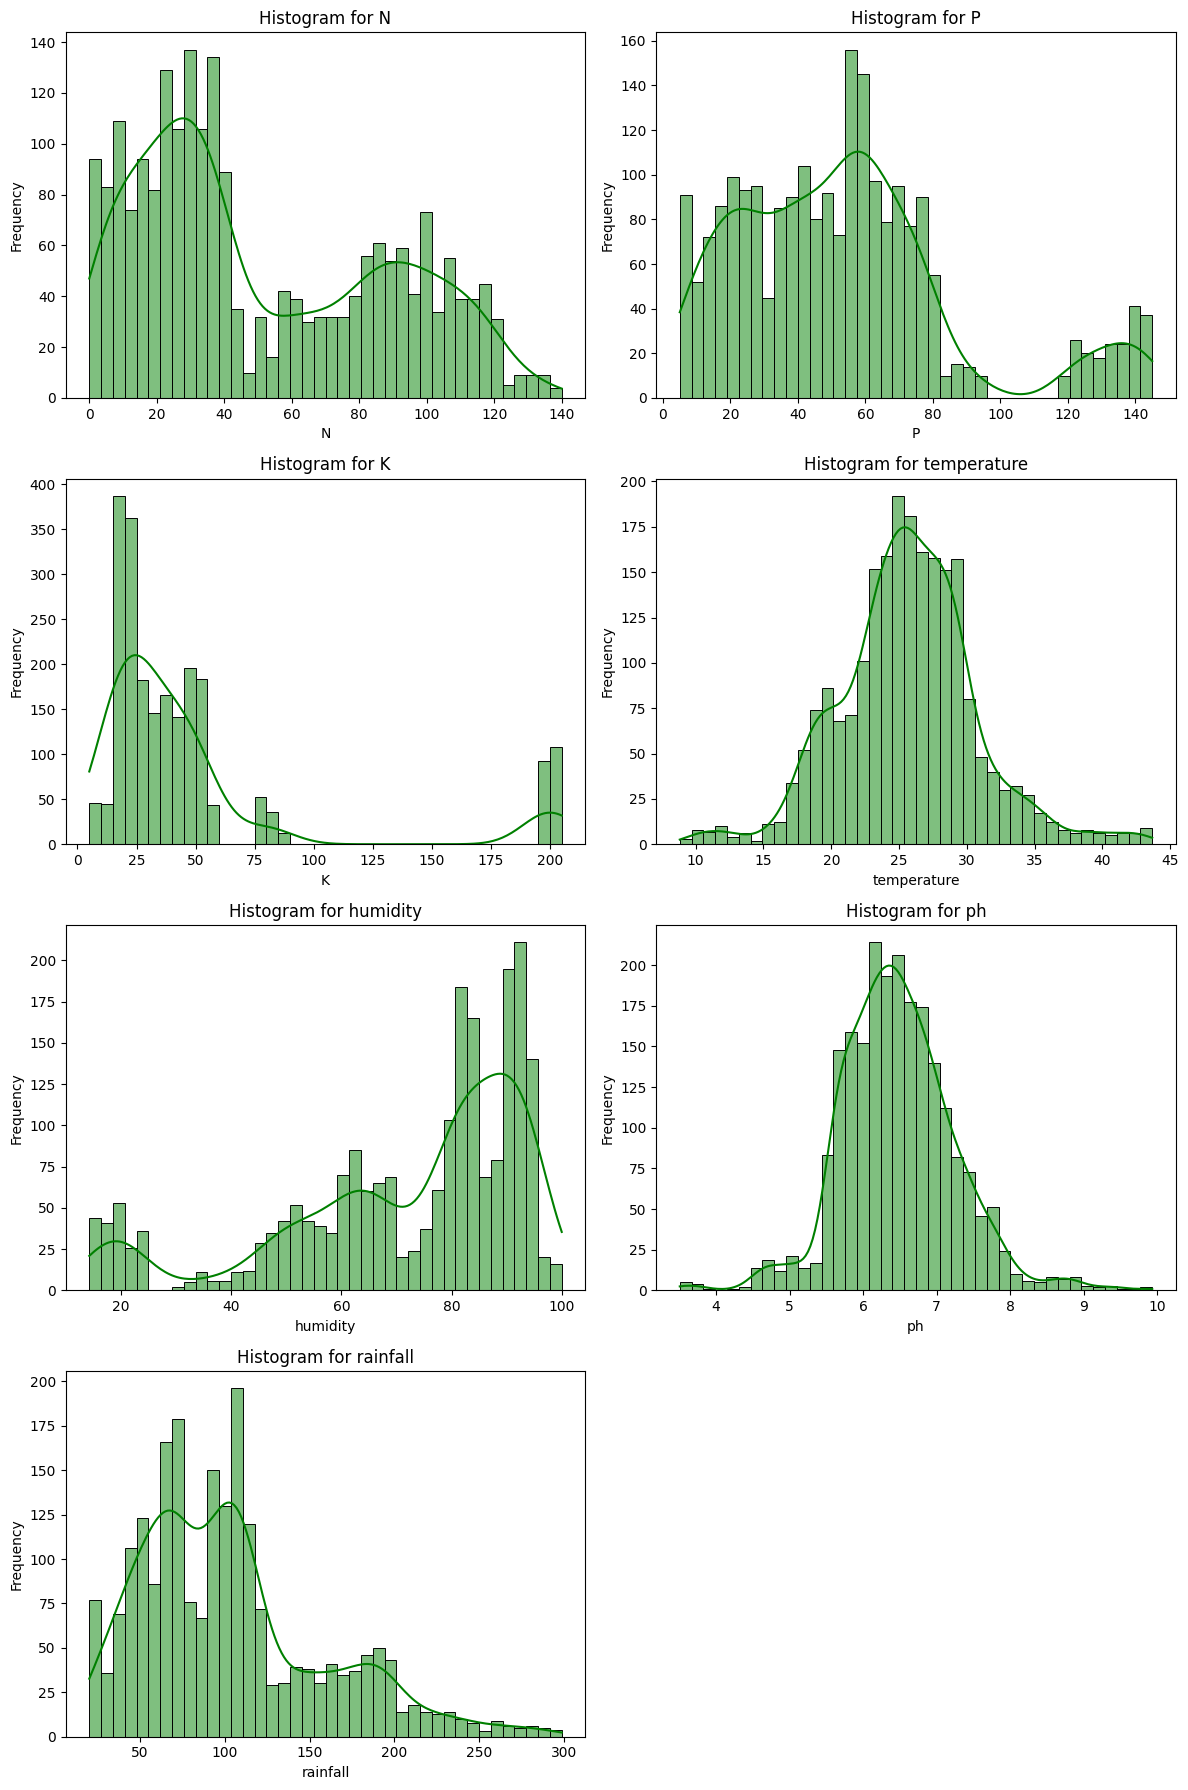

In [11]:
fig,axs=plt.subplots(4,2,figsize=(12,18))
axs=axs.ravel()
for i in range(n):
    sns.histplot(df[cols[i]], bins=40, kde=True, ax=axs[i], color="green")
    axs[i].set_title(f"Histogram for {cols[i]}")
    axs[i].set_ylabel("Frequency")
for j in range(n, len(axs)):
    fig.delaxes(axs[j])
plt.tight_layout()
plt.show()

# Average Temp for crops 

/tmp/ipykernel_59120/1746428265.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="label",x="temperature",data=grouped_label_data,palette="YlGnBu")


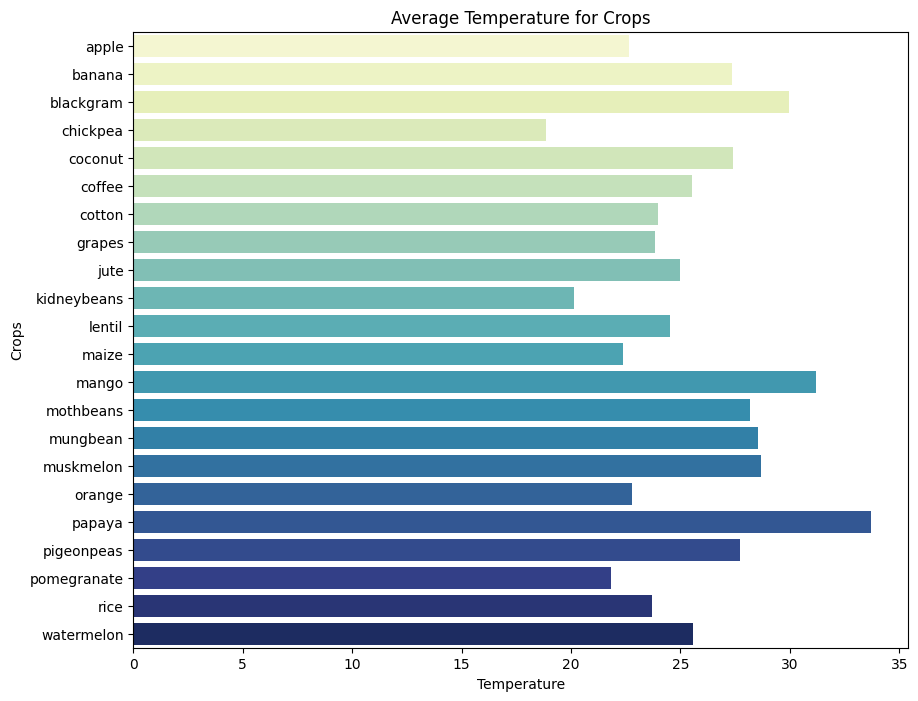

In [12]:
grouped_label_data=df.groupby("label")["temperature"].mean().reset_index()
plt.figure(figsize=(10,8))
sns.barplot(y="label",x="temperature",data=grouped_label_data,palette="YlGnBu")
plt.ylabel("Crops")
plt.title("Average Temperature for Crops")
plt.xlabel("Temperature")
plt.show()

# Measure of N, P, K Levels per Crops

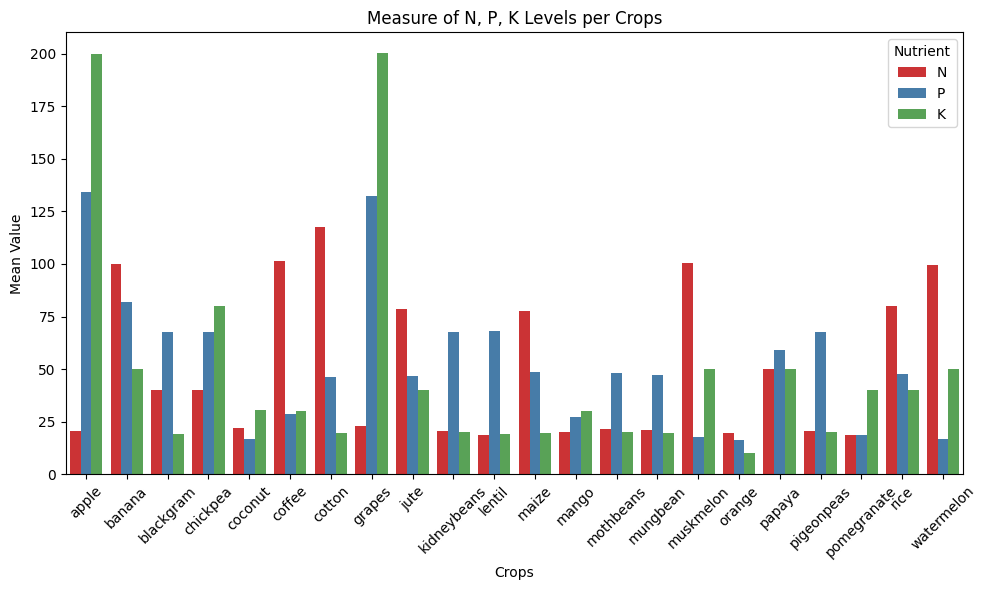

In [13]:
group_npk = df.groupby("label")[["N", "P", "K"]].mean().reset_index()
melted = group_npk.melt(id_vars="label", value_vars=["N", "P", "K"],var_name="Nutrient", value_name="Mean Value")

plt.figure(figsize=(10,6))
sns.barplot(x="label", y="Mean Value", hue="Nutrient", data=melted, palette="Set1")
plt.title("Measure of N, P, K Levels per Crops")
plt.ylabel("Mean Value")
plt.xlabel("Crops")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Predictive Modeling

In [ ]:
data = df.copy()
data.columns = ["V" + str(i) for i in range(1, 9)]

In [ ]:
for col in CONTINOUS_COLUMNS:
    data[col] = pd.to_numeric(data[col], errors='coerce')

In [ ]:
X = data.drop(["V8"],axis=1)
y = data["V8"]

In [23]:
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
crop_train = pd.concat([X_train, y_train], axis=1)
crop_test = pd.concat([X_test, y_test], axis=1)

crop_train.to_csv('streamlit_evidentlyai/crop_train.csv', index=False)
crop_train.to_csv('streamlit_evidentlyai/crop_test.csv', index=False)

In [17]:
standard_scaler_list = []
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=42)

standard_scaler_dict = {}
for col in CONTINOUS_COLUMNS:
    ss = StandardScaler()
    X_train[[col]] = ss.fit_transform(X_train[[col]])
    X_test[[col]] = ss.transform(X_test[[col]])
    standard_scaler_dict[col] = ss

# Save dictionary of scalers
with open('artifacts/encoders/standard_scaler_dict.pkl', 'wb') as file:
    pickle.dump(standard_scaler_dict, file)

In [7]:
model=RandomForestClassifier(n_estimators=100)
model.fit(X_train,y_train)

RandomForestClassifier()

Save df and standard scaler object

In [8]:
from pathlib import Path

# Creating folders
def create_new_folder(folder):
    Path(folder).mkdir(parents=True, exist_ok=True)

folder = 'artifacts/encoders'
create_new_folder(folder)

folder = 'artifacts/preprocessed_data'
create_new_folder(folder)

In [20]:
X_processed = pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_test)], axis=0)

In [ ]:
processed_data = pd.concat([X_processed, y])
processed_data.to_csv('artifacts/preprocessed_data/saved_dataframe_new.csv', index=False)

In [9]:
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='macro')  
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')

roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"ROC AUC: {roc_auc}")

Accuracy: 0.9931818181818182
F1 Score: 0.9926374055074331
Precision: 0.9925757575757576
Recall: 0.9933213716108454
ROC AUC: 0.9999104597390226


In [25]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        26
     coconut       1.00      1.00      1.00        27
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        17
      grapes       1.00      1.00      1.00        14
        jute       0.92      1.00      0.96        23
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.92      1.00      0.96        11
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        19
   mothbeans       1.00      0.96      0.98        24
    mungbean       1.00      1.00      1.00        19
   muskmelon       1.00      1.00      1.00        17
      orange       1.00      1.00      1.00        14
  

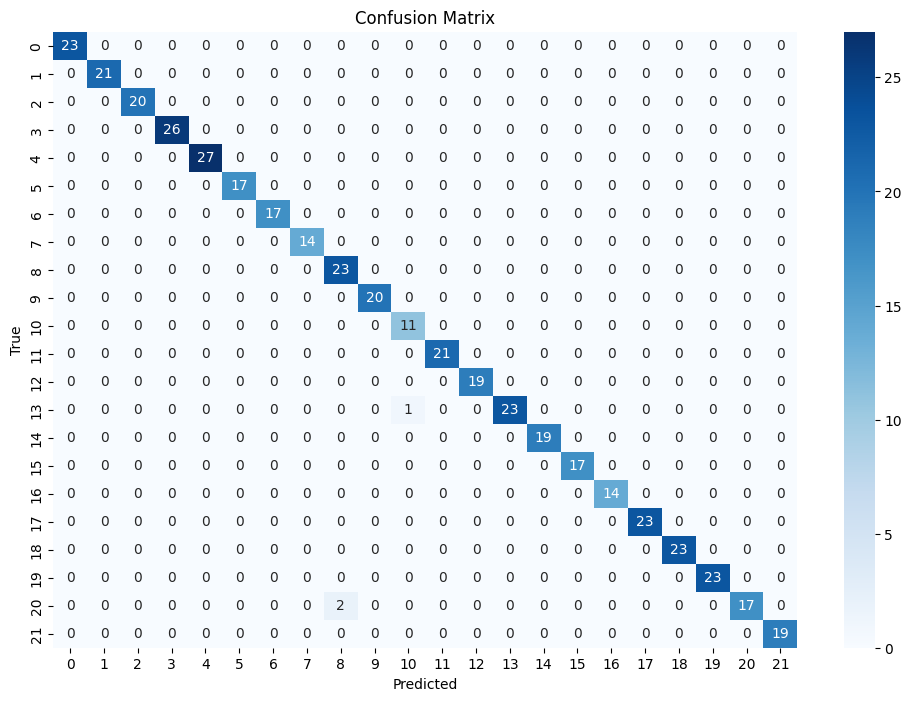

In [26]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [27]:
with open("artifacts/models/random_forest_model.pkl","wb") as file:
    pickle.dump(model,file)

In [22]:
with open("artifacts/models/random_forest_model.pkl","rb") as file:
    clf=pickle.load(file)

In [12]:
X_new_values = [[100,40,35,27.56441788,54.41094079,6.9557873510000015,177.816092]]

with open('artifacts/encoders/standard_scaler_dict.pkl', 'rb') as file:
    standard_scaler_dict = pickle.load(file)

with open("artifacts/models/random_forest_model.pkl","rb") as file:
    clf=pickle.load(file)


X_new = pd.DataFrame(X_new_values, columns=CONTINOUS_COLUMNS)
    
for col in CONTINOUS_COLUMNS:
    X_new[[col]] = standard_scaler_dict[col].transform(X_new[[col]])

y_predi = clf.predict(X_new)
print("Predictions:", y_predi)


Predictions: ['coffee']
